In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import os
import requests

***Loading Dataset: Geo-Referenced Carbon Emissions***

In [2]:
url='https://old.datahub.io/dataset/5402a22d-e9d8-402f-a929-4231af29bfe3/resource/dc220278-bc1d-4b76-bebe-3d370a6ae521/download/fossil-fuel-co2-emissions-by-nation.csv'

nations_df = pd.read_csv(url)

***Understand Column Meanings***

In [3]:
nations_df.head()

,Year,Country,Total,Solid Fuel,Liquid Fuel,Gas Fuel,Cement,Gas Flaring,Per Capita,Bunker fuels (Not in Total)
0,1751,UNITED KINGDOM,2552,2552,0,0,0,0,0.0,0
1,1752,UNITED KINGDOM,2553,2553,0,0,0,0,0.0,0
2,1753,UNITED KINGDOM,2553,2553,0,0,0,0,0.0,0
3,1754,UNITED KINGDOM,2554,2554,0,0,0,0,0.0,0
4,1755,UNITED KINGDOM,2555,2555,0,0,0,0,0.0,0


***Check Data Integrity***

In [4]:
# Check for missing values
missing_values = nations_df.isnull().sum()

# Display the count of missing values for each column
print("Missing Values Summary:")
print(missing_values)

Missing Values Summary:
Year                           0
Country                        0
Total                          0
Solid Fuel                     0
Liquid Fuel                    0
Gas Fuel                       0
Cement                         0
Gas Flaring                    0
Per Capita                     0
Bunker fuels (Not in Total)    0
dtype: int64


***Visualize Distributions***

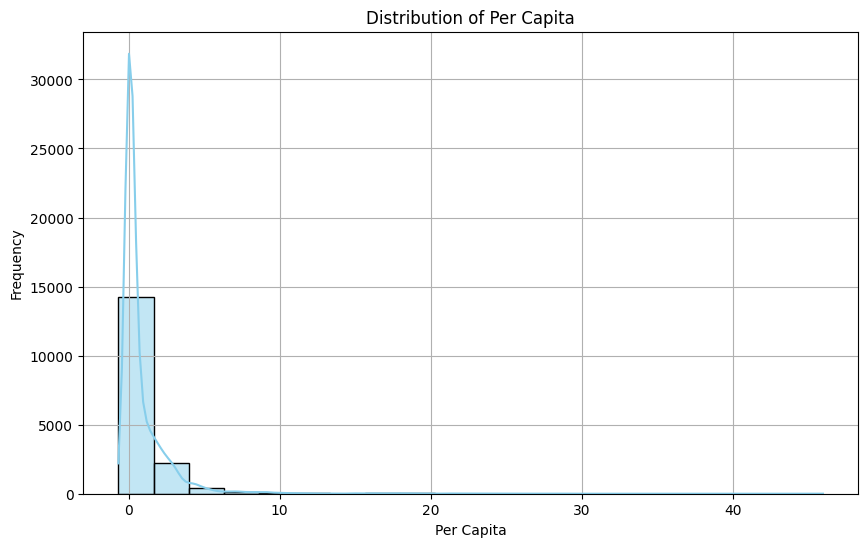

In [12]:
# Select the column you want to analyze (replace 'Per Capita' with the actual column name)
column_to_analyze = 'Per Capita'

# Create a distribution plot (histogram) to visualize the data
plt.figure(figsize=(10, 6))
sns.histplot(nations_df[column_to_analyze], kde=True, bins=20, color='skyblue')
plt.title(f'Distribution of {column_to_analyze}')
plt.xlabel(column_to_analyze)
plt.ylabel('Frequency')
plt.grid(True)

# Show the plot
plt.show()


***Pair Plots for Relationships***

In [6]:
# Question: should we plot the correlation of all the columns?
#sns.heatmap(nations_df.corr())

<Axes: >

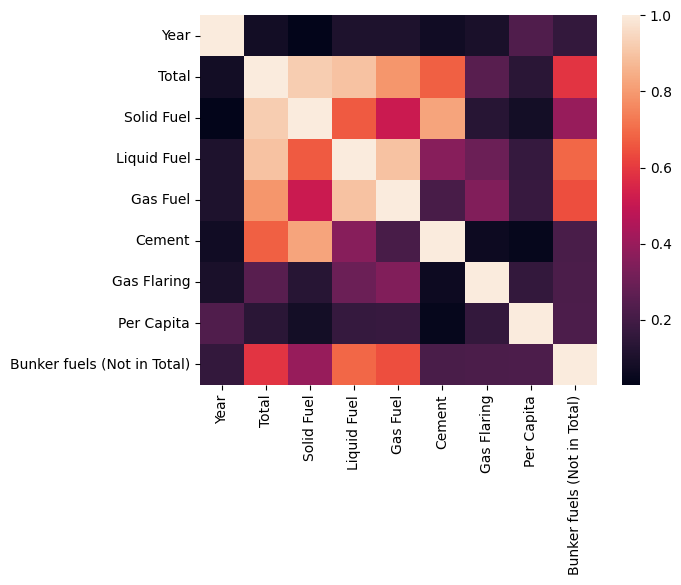

In [7]:
# Remove non-numeric columns before calculating correlation
numeric_df = nations_df.select_dtypes(include=['number'])

# Calculate the correlation matrix for numeric columns
corr_matrix = numeric_df.corr()

# Create the heatmap
sns.heatmap(corr_matrix)

***Understanding a Time Series***

<Axes: xlabel='Year', ylabel='Total'>

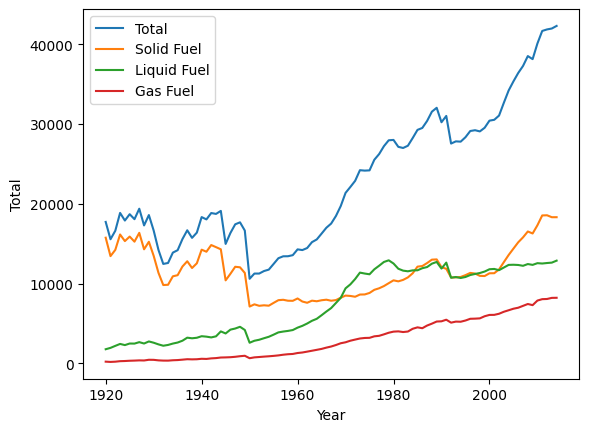

In [8]:
# Set the matplotlib canva
fig, ax = plt.subplots()

# Optional: Query the data by year: selects all rows in which the 'Year' column has a value greater than or equal to 1920
query_df = nations_df[nations_df['Year'] >= 1920]

# Select only numeric columns for calculating the mean
numeric_df = query_df.select_dtypes(include=['number'])

# Optional: evaluate the mean once for all and then plot
query_df = numeric_df.groupby('Year').mean()

# Plot the time series
sns.lineplot(data=query_df, x='Year', y='Total', ax=ax, legend='brief', label='Total')
sns.lineplot(data=query_df, x='Year', y='Solid Fuel', ax=ax, legend='brief', label='Solid Fuel')
sns.lineplot(data=query_df, x='Year', y='Liquid Fuel', ax=ax, legend='brief', label='Liquid Fuel')
sns.lineplot(data=query_df, x='Year', y='Gas Fuel', ax=ax, legend='brief', label='Gas Fuel')

***Plot Geo-Referenced Data with Geopandas***

--2024-09-25 12:50:30--  https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip
Resolving naturalearth.s3.amazonaws.com (naturalearth.s3.amazonaws.com)... 52.218.132.171, 52.218.133.153, 52.218.169.219, ...
Connecting to naturalearth.s3.amazonaws.com (naturalearth.s3.amazonaws.com)|52.218.132.171|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 214976 (210K) [application/zip]
Saving to: ‘ne_110m_admin_0_countries.zip’

ne_110m_admin_0_cou 100%[===================>] 209.94K  1.06MB/s    in 0.2s    

2024-09-25 12:50:30 (1.06 MB/s) - ‘ne_110m_admin_0_countries.zip’ saved [214976/214976]

Archive:  ne_110m_admin_0_countries.zip
  inflating: ne_110m_admin_0_countries.README.html  
 extracting: ne_110m_admin_0_countries.VERSION.txt  
 extracting: ne_110m_admin_0_countries.cpg  
  inflating: ne_110m_admin_0_countries.dbf  
  inflating: ne_110m_admin_0_countries.prj  
  inflating: ne_110m_admin_0_countries.shp  
  inflating: ne_110m_admin_0_

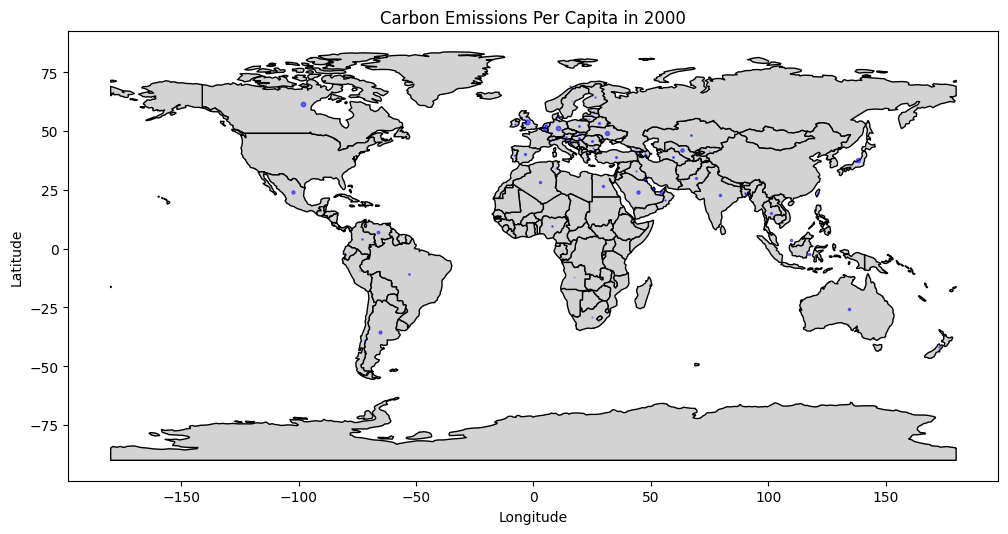

<Figure size 640x480 with 0 Axes>

In [9]:
#!pip install geopandas

import geopandas as gpd
import matplotlib.pyplot as plt

# Load a world map shapefile or GeoDataFrame (you may need to download this dataset)
#world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Download the shapefile from naturalearthdata.com
!wget https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip
!unzip ne_110m_admin_0_countries.zip

# Load the world map from the downloaded shapefile
world = gpd.read_file('ne_110m_admin_0_countries.shp')

available_countries = world['NAME'].unique()

# Select the year you want to analyze
year_to_plot = 2000
column_to_plot = 'Gas Fuel'
# Filter the data for the selected year
data_for_year = nations_df[nations_df['Year'] == year_to_plot]

# Plot the world map
world.plot(figsize=(12, 8), color='lightgray', edgecolor='k')

min_col = data_for_year[column_to_plot].min()
max_col = data_for_year[column_to_plot].max()
# Plot balloons at each country's location with size based on 'Per Capita'
for idx, row in data_for_year.iterrows():
    country = row['Country'].title()
    if country not in available_countries: continue
    value = row[column_to_plot]
    value_normalized = (value - min_col) / (max_col - min_col)
    # Find the geometry (coordinates) for the country in the world map

    geometry = world[world['NAME'] == country]['geometry'].values[0]

    # Extract latitude and longitude from the geometry
    lon, lat = geometry.centroid.xy

    # Plot a circle (balloon) with size based on 'Per Capita'
    plt.scatter(lon, lat, s=value_normalized * 75, color='blue', alpha=0.5)

# Set plot title and labels
plt.title(f'Carbon Emissions Per Capita in {year_to_plot}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot and save
plt.show()
plt.savefig(f'year_{year_to_plot}.pdf')